# Redes Neurais Convolucionais (CNN)

In [1]:
# Adaptação para utilizar a sintaxe do TensorFlor 1.x no TensorFlow 2.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


<br/> 
## Classificação com Redes Neurais Convolucionais (CNN)

In [4]:
data = mnist.load_data()

In [5]:
x_train = np.asarray(data[0][0], dtype=np.float32) # 60k dados (28x28) de treino
x_test = np.asarray(data[1][0], dtype=np.float32)  # 10k dados (28x28) de teste
y_train = np.asarray(data[0][1], dtype=np.int32)
y_test = np.asarray(data[1][1], dtype=np.int32)

In [6]:
# Normalização
x_train = np.array(list(map(lambda x: x / 255., [item for item in x_train])))
x_test = np.array(list(map(lambda x: x / 255., [item for item in x_test])))

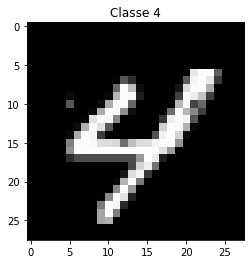

In [7]:
reg = 89
plt.imshow(x_train[reg], cmap='gray')
plt.title('Classe {}'.format(y_train[reg]))
plt.show()

In [8]:
# É obrigatorio ter os parametros 'features', 'labels'
def create_NN(features, labels, mode):
    input_layer = tf.reshape(features['x'], shape=(-1,28,28,1))
     # shape: batch_size, largura, altura, canais
    
    # Processos de Convolução, Pooling e Flattening
    # input (batch_size, 28, 28, 1) -> output (batch_size, 28, 28, 32)
    conv1 = tf.layers.conv2d(input_layer, filters=32, kernel_size=(5,5), activation=tf.nn.relu, padding='same')
    
    # input (batch_size, 28, 28, 32) -> output (batch_size, 14, 14, 32)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=2)
    
    # input (batch_size, 14, 14, 32) -> output (batch_size, 14, 14, 64)
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=(5,5), activation=tf.nn.relu, padding='same')
    
    # input (batch_size, 14, 14, 64) -> output (batch_size, 7, 7, 64)
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=2)
    
    # input (batch_size, 7, 7, 64) -> output (batch_size, 3136)
    flat = tf.reshape(pool2, shape=(-1, 7*7*64))
    
    
    # Estrutura da RNA (3136 - 1024 - 10)
    hidden_layer = tf.layers.dense(flat, units=1024, activation=tf.nn.relu)
    
    dropout_layer = tf.layers.dropout(hidden_layer, rate=0.2, training= (mode == tf.estimator.ModeKeys.TRAIN))
    # somente aplica o droput quando estiver em modo de treinamento
    
    output_layer = tf.layers.dense(dropout_layer, units=10)
    
    previsoes = tf.argmax(output_layer, axis=1)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=previsoes)
    
    
    erro = tf.losses.sparse_softmax_cross_entropy(labels, logits=output_layer)
    # sparse softmax usada quando o target não passou por one_hot_encoder
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        otimizador = tf.train.AdamOptimizer(learning_rate=0.001)
        treinamento = otimizador.minimize(erro, global_step=tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode, loss=erro, train_op=treinamento)
    
    
                          
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics = {'accuracy' : tf.metrics.accuracy(labels, previsoes)}
        
        return tf.estimator.EstimatorSpec(mode, loss=erro, eval_metric_ops=eval_metrics)

In [9]:
# Cria um estimator não pre-definido
classificador = tf.estimator.Estimator(model_fn= create_NN)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmphoc81j3x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Processo de Treino e Teste

In [10]:
# Cria a função de treinamento e teste
funcao_train = tf.estimator.inputs.numpy_input_fn(x={'x': x_train}, y=y_train,
                                                 batch_size=128, num_epochs=None, shuffle=True)
 # key 'x' deve ser identico ao definido na funcão create_NN

funcao_test = tf.estimator.inputs.numpy_input_fn(x={'x': x_test}, y=y_test, num_epochs=1, shuffle=False)

In [ ]:
# Realiza o treinamento
classificador.train(input_fn=funcao_train, steps=400)

In [12]:
# Realiza o Teste
precisao = classificador.evaluate(input_fn=funcao_test)
precisao

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-24T19:40:01Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmphoc81j3x/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 4.84527s
INFO:tensorflow:Finished evaluation at 2020-03-24-19:40:05
INFO:tensorflow:Saving dict for global step 400: accuracy = 0.9878, global_step = 400, loss = 0.035944033
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 400: /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmphoc81j3x/model.ckpt-400


{'accuracy': 0.9878, 'loss': 0.035944033, 'global_step': 400}

#### Processo de Previsão

In [13]:
# Realiza a Previsão
range_val = range(10, 20)
x_validate = x_test[range_val]
x_validate = x_validate.reshape(len(range_val), -1)
x_validate.shape

(10, 784)

In [14]:
# Cria a função de previsão
funcao_predict = tf.estimator.inputs.numpy_input_fn(x={'x': x_validate}, shuffle=False)

In [15]:
previsoes = list(classificador.predict(input_fn=funcao_predict))
previsoes

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmphoc81j3x/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

Esperado: [0 6 9 0 1 5 9 7 3 4]


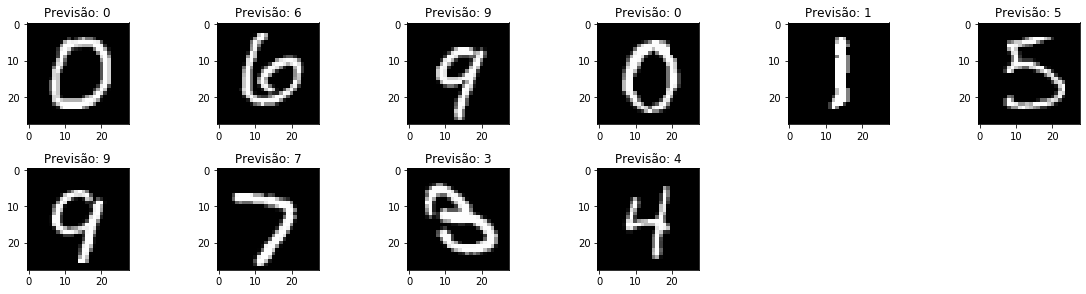

In [16]:
# Verifica o Resultado da Previsão
print('Esperado: {}'.format(y_test[range_val]))

plt.figure(figsize=(16,8))
i=1
for img in x_validate:
    plt.subplot(4,6,i)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title('Previsão: {}'.format(previsoes[i-1]))
    plt.tight_layout()
    i += 1